In [16]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Plot styling (matches CF)
plt.style.use('fivethirtyeight')


In [17]:
# Load data

df = pd.read_csv(r"C:\Users\rbaue\Desktop\airbnb_clean.csv")
df.head()

,id,name,neighbourhood,latitude,longitude,room_type,property_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,host_is_superhost,instant_bookable
0,90676,Short North - Italianate Cottage,Neighborhood highlights,39.98366,-83.00252,Entire home/apt,Entire home,128,1,868,5.11,155,t,f
1,591101,Bellows Studio Loft Apartment,Neighborhood highlights,39.96041,-82.98005,Private room,Private room in loft,112,2,342,2.14,339,t,f
2,927867,Full Private Room at the Hostel,Neighborhood highlights,40.01259,-83.00164,Private room,Private room in hostel,105,1,82,0.56,292,f,f
3,1183297,Hannah's Haus**Prime location in German Village**,Neighborhood highlights,39.95164,-82.99434,Entire home/apt,Entire home,253,30,87,1.80,288,t,f
4,1217678,Comfortable rooms in Clintonville 1,Neighborhood highlights,40.03869,-83.01728,Private room,Private room in home,74,1,283,1.90,342,t,f


In [18]:
df.shape

(1259, 14)

In [19]:
df.columns

Index(['id', 'name', 'neighbourhood', 'latitude', 'longitude', 'room_type',
       'property_type', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'availability_365', 'host_is_superhost',
       'instant_bookable'],
      dtype='object')

In [20]:
type(df)

pandas.core.frame.DataFrame

In [21]:
df.dtypes

id                     int64
name                  object
neighbourhood         object
latitude             float64
longitude            float64
room_type             object
property_type         object
price                  int64
minimum_nights         int64
number_of_reviews      int64
reviews_per_month    float64
availability_365       int64
host_is_superhost     object
instant_bookable      object
dtype: object

In [22]:
df.head(3)

,id,name,neighbourhood,latitude,longitude,room_type,property_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,host_is_superhost,instant_bookable
0,90676,Short North - Italianate Cottage,Neighborhood highlights,39.98366,-83.00252,Entire home/apt,Entire home,128,1,868,5.11,155,t,f
1,591101,Bellows Studio Loft Apartment,Neighborhood highlights,39.96041,-82.98005,Private room,Private room in loft,112,2,342,2.14,339,t,f
2,927867,Full Private Room at the Hostel,Neighborhood highlights,40.01259,-83.00164,Private room,Private room in hostel,105,1,82,0.56,292,f,f


In [23]:
# Create a synthetic time index (one observation per row)
df["Date"] = pd.date_range(start="2018-01-01", periods=len(df), freq="D")

df[["Date","price"]].head()


,Date,price
0,2018-01-01,128
1,2018-01-02,112
2,2018-01-03,105
3,2018-01-04,253
4,2018-01-05,74


In [44]:
ts = (df.groupby("Date")["price"]
      .mean()
      .to_frame(name="Value")
      .sort_index())

ts.head()


,Value
Date,
2018-01-01,128.0
2018-01-02,112.0
2018-01-03,105.0
2018-01-04,253.0
2018-01-05,74.0


In [31]:
ts_plot = ts_sub.copy()
ts_plot["Value_capped"] = ts_plot["Value"].clip(upper=500)   # cap at $500


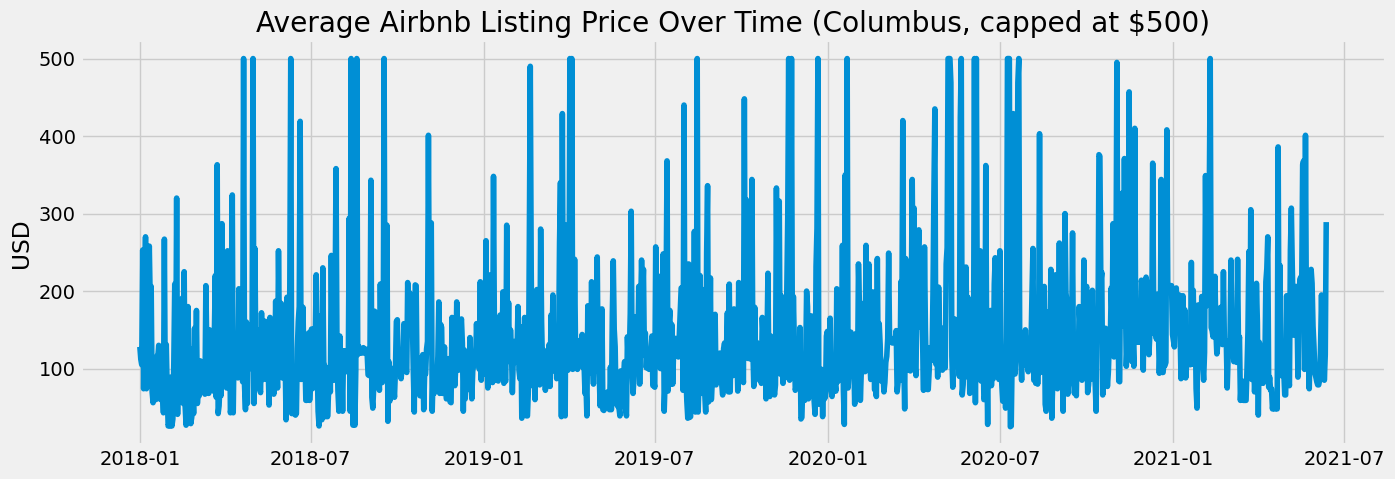

In [32]:
# Plot

plt.figure(figsize=(15,5), dpi=100)
plt.plot(ts_plot.index, ts_plot["Value_capped"])
plt.title("Average Airbnb Listing Price Over Time (Columbus, capped at $500)")
plt.ylabel("USD")
plt.show()


In [33]:
# Reset index and subset

ts2 = ts.reset_index()
ts2.head()


,Date,Value
0,2018-01-01,128.0
1,2018-01-02,112.0
2,2018-01-03,105.0
3,2018-01-04,253.0
4,2018-01-05,74.0


In [42]:
ts_sub = ts2.loc[
    (ts2["Date"] >= "2018-01-01") & 
    (ts2["Date"] <= "2021-06-30")]

ts_sub.shape


(1259, 2)

In [35]:
# Set date as index

ts_sub["datetime"] = pd.to_datetime(ts_sub["Date"])
ts_sub = ts_sub.set_index("datetime")
ts_sub.drop("Date", axis=1, inplace=True)

ts_sub.head()


,Value
datetime,
2018-01-01,128.0
2018-01-02,112.0
2018-01-03,105.0
2018-01-04,253.0
2018-01-05,74.0


In [29]:
# Cleaning

ts_sub.isnull().sum()
ts_sub.duplicated().sum()


np.int64(959)

In [37]:
ts_clean = ts_sub[ts_sub["Value"] <= 500].copy()


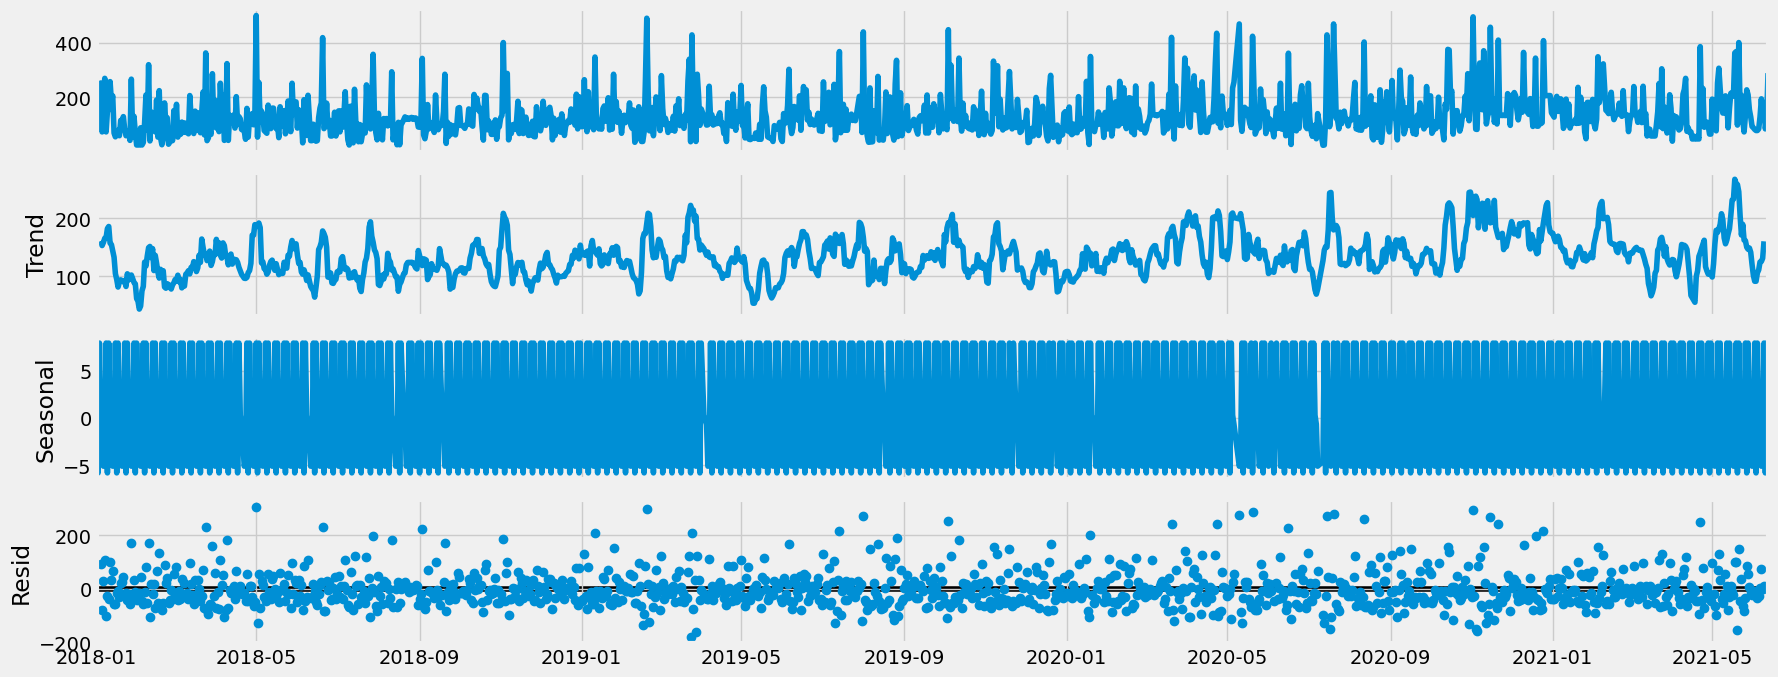

In [38]:
# Decomposition

decomposition = sm.tsa.seasonal_decompose(ts_clean, model="additive", period=7)

from pylab import rcParams
rcParams["figure.figsize"] = 18, 7

decomposition.plot()
plt.show()



In [39]:
# Dickey-Fuller test

from statsmodels.tsa.stattools import adfuller

def dickey_fuller(series):
    print("Dickey-Fuller Stationarity test:")
    test = adfuller(series, autolag="AIC")
    result = pd.Series(test[0:4],
                       index=["Test Statistic","p-value","Number of Lags Used","Number of Observations Used"])
    for key, value in test[4].items():
        result[f"Critical Value ({key})"] = value
    print(result)

dickey_fuller(ts_sub["Value"])


Dickey-Fuller Stationarity test:
Test Statistic                -7.590461e+00
p-value                        2.539524e-11
Number of Lags Used            2.000000e+01
Number of Observations Used    1.238000e+03
Critical Value (1%)           -3.435643e+00
Critical Value (5%)           -2.863877e+00
Critical Value (10%)          -2.568014e+00
dtype: float64


After removing extreme outliers from the Columbus Airbnb price data, the time series decomposition shows a stable trend with a consistent weekly seasonal pattern. The residual component is centered around zero, indicating that most systematic structure has been captured by the trend and seasonal components.

The Dickey-Fuller test confirms that the series is stationary (test statistic = −7.59, p < 0.001), allowing for further time-series modeling without the need for differencing

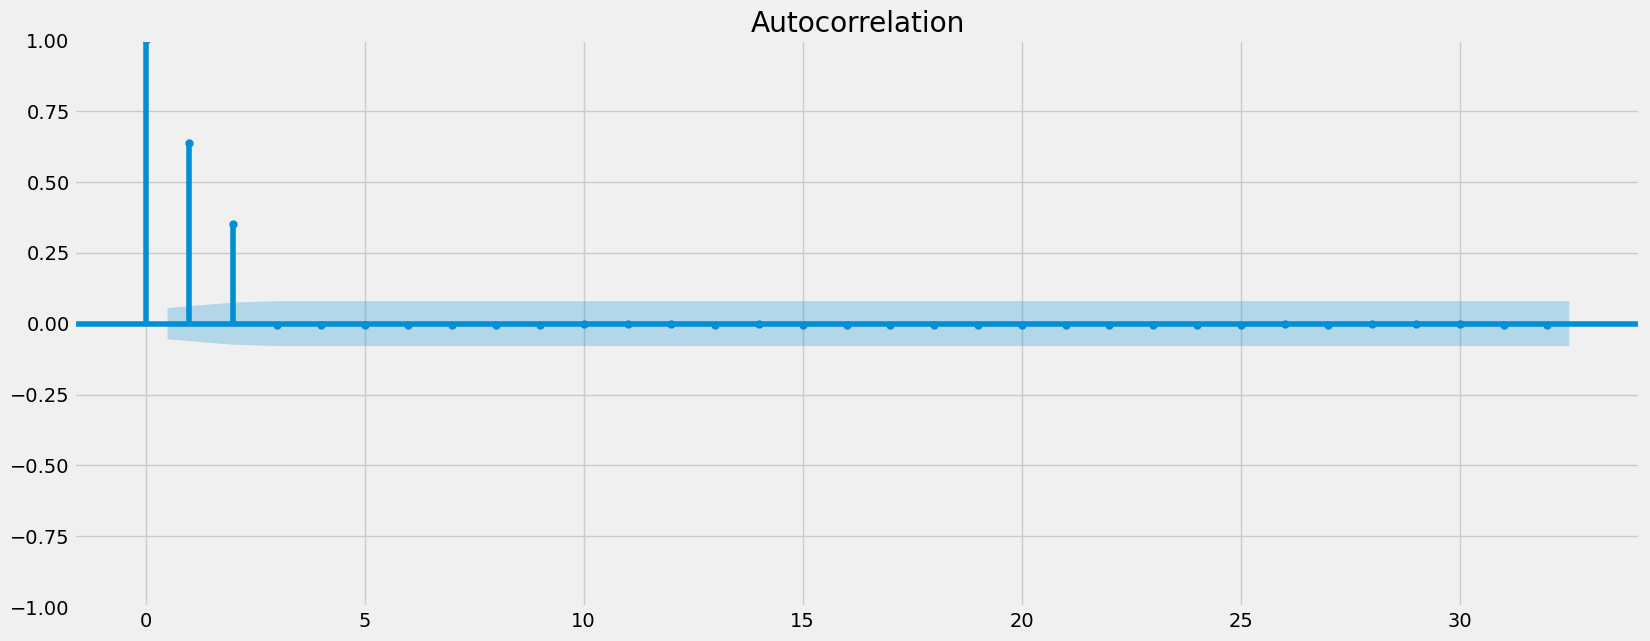

In [41]:
# Checking autocorrelation

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_sub)
plt.show()


The autocorrelation plot shows that only the first few lags are significantly correlated while the remaining lags fall within the confidence intervals. This confirms that the series is stationary.